In [31]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cartopy.crs as ccrs
from shapely.geometry import box, mapping
import pyproj
import geopandas as gpd

from renewable_data_load import *
from climakitae.util.utils import clip_to_shapefile

# 1. Load drought masks and shapefiles

In [32]:
# Analysis parameters
domain = "d02"
variable = "cf"
reference_gwl = 0.8
target_gwls = [0.8, 2.0]
simulation = "ec-earth3"

# Available simulations
simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]

# Data directory
data_dir = Path("../../data/drought_masks")

In [33]:
def load_drought_mask(resource, module, domain, variable, simulation, gwl, data_dir="../../data/drought_masks"):
    """
    Load a drought mask from zarr store.
    
    Parameters
    ----------
    resource : str
        Resource type ('pv' or 'windpower')
    module : str
        Module type ('utility', 'distributed', 'onshore', 'offshore')
    domain : str
        Domain ('d02' or 'd03')
    variable : str
        Variable ('cf' or 'gen')
    simulation : str
        Climate model simulation name
    gwl : float
        Global warming level (0.8, 1.5, 2.0, 3.0, etc.)
    data_dir : str or Path
        Directory containing drought mask files
        
    Returns
    -------
    xr.DataArray
        Drought mask (1 = drought, 0 = no drought)
    """
    mask_file = f"{resource}_{module}_{domain}_{variable}_{simulation}_gwl{gwl}_drought_mask_only.zarr"
    mask_path = Path(data_dir) / mask_file
    
    if not mask_path.exists():
        raise FileNotFoundError(f"Drought mask not found: {mask_path}")
    
    # Open zarr store with consolidated metadata
    ds = xr.open_zarr(mask_path, consolidated=True)
    
    return ds['drought_mask']

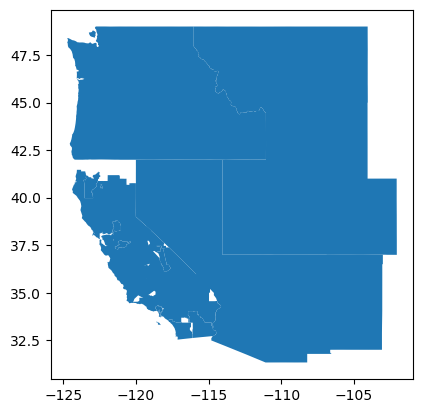

In [34]:
# load shapefile to examine
shapefile_path = Path("../../data/load_zone_shapefiles/allLoadZones.shp")

gdf = gpd.read_file(shapefile_path)
gdf.plot()

# need to manually set the CRS for the drought mask
wrf_crs = pyproj.CRS(
        """+proj=lcc +lat_0=38. +lon_0=-70. +lat_1=30.
        +lat_2=60. +R=6370000. +units=m +no_defs"""
    )



# and set the shapefile to the same CRS
gdf_reprojected = gdf.to_crs(wrf_crs.to_string())

In [48]:
all_drought_mask = []
for (resource, module) in [("pv","utility"), ("windpower","onshore")]:
    resource_masks = []
    for target_gwl in target_gwls:
        gwl_masks = []
        for simulation in simulations:
            simulation_masks = []

            print(f"Processing {resource} {module} GWL {target_gwl} Simulation {simulation}")
            drought_mask = load_drought_mask(
                resource=resource,
                module=module,
                domain=domain,
                variable=variable,
                simulation=simulation,
                gwl=target_gwl,
                data_dir=data_dir
            )

            # need to set the CRS for the drought mask
            drought_mask = drought_mask.rio.write_crs(wrf_crs)
            drought_mask = drought_mask + 1

            region_masks = []

            for index, row in gdf_reprojected.iterrows():
                region_name = row['name']
                geom = [mapping(row.geometry)]

                region_mask = drought_mask.rio.clip(
                geom,
                crs=wrf_crs,
                drop=True,
                all_touched=True,
                )

                # Convert 0s to NaN and 1s to 0 (so that drought areas are NaN and non-drought areas are 0)
                region_mask = region_mask.where(region_mask != 0, np.nan)
                region_mask = region_mask - 1

                region_mask['simulation'] = simulation
                region_mask['target_gwl'] = target_gwl
                region_mask['region'] = region_name
                region_mask['resource'] = resource
                region_mask['module'] = module

                region_masks.append(region_mask)
            region_masks_ds = xr.concat(region_masks, dim='region', join='outer')
            resource_masks.append(region_masks_ds)
        gwl_masks.append(xr.concat(resource_masks, dim='simulation', join='outer'))
    all_drought_mask.append(xr.concat(gwl_masks, dim='target_gwl', join='outer'))



Processing pv utility GWL 0.8 Simulation mpi-esm1-2-hr


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

Processing pv utility GWL 0.8 Simulation miroc6


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

Processing pv utility GWL 0.8 Simulation taiesm1


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

Processing pv utility GWL 0.8 Simulation ec-earth3


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

Processing pv utility GWL 2.0 Simulation mpi-esm1-2-hr


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

Processing pv utility GWL 2.0 Simulation miroc6


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

Processing pv utility GWL 2.0 Simulation taiesm1


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

Processing pv utility GWL 2.0 Simulation ec-earth3


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_40765/280538994.py:48: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  region_masks_ds = xr.concat(region_masks, dim='region')
/var

ValueError: target_gwl already exists as coordinate or variable name.

In [ ]:
all_drought_mask

In [54]:
region_masks = []

for target_gwl in target_gwls:
    for simulation in simulations:

        # Load drought masks for solar and wind
        print(f"Loading drought masks for {simulation} at GWL {target_gwl}°C...")

        solar_mask = load_drought_mask(
            resource="pv",
            module="utility",
            domain=domain,
            variable=variable,
            simulation=simulation,
            gwl=target_gwl,
            data_dir=data_dir
        )

        wind_mask = load_drought_mask(
            resource="windpower",
            module="onshore",
            domain=domain,
            variable=variable,
            simulation=simulation,
            gwl=target_gwl,
            data_dir=data_dir
        )

        solar_mask = solar_mask.rio.write_crs(wrf_crs)
        wind_mask = wind_mask.rio.write_crs(wrf_crs)

        for (resource, module, drought_mask) in [("pv","utility",solar_mask), ("windpower","onshore",wind_mask)]:

            drought_mask = drought_mask+1
            for idx, row in gdf_reprojected.iterrows():
                region_name = row['name']
                geom = [mapping(row.geometry)]

                region_mask = drought_mask.rio.clip(
                geom,
                crs=wrf_crs,
                drop=True,
                all_touched=True,
                )

                # replace 0s with nans for easier averaging later
                region_mask = region_mask.where(region_mask != 0, np.nan)
                region_mask = region_mask - 1

                region_mask['simulation'] = simulation
                region_mask['target_gwl'] = target_gwl
                region_mask['region'] = region_name
                region_mask['resource'] = resource
                region_mask['module'] = module

                region_mask['drought_area_fraction'] = region_mask.mean(['x','y'])

                output_file = f"{region_name}_{simulation}_{resource}_{module}_gwl{target_gwl}_drought_area_fraction.nc"
                region_mask['drought_area_fraction'].to_netcdf('drought_masks/'+output_file)


Loading drought masks for mpi-esm1-2-hr at GWL 0.8°C...
Loading drought masks for miroc6 at GWL 0.8°C...
Loading drought masks for taiesm1 at GWL 0.8°C...
Loading drought masks for ec-earth3 at GWL 0.8°C...
Loading drought masks for mpi-esm1-2-hr at GWL 2.0°C...
Loading drought masks for miroc6 at GWL 2.0°C...
Loading drought masks for taiesm1 at GWL 2.0°C...
Loading drought masks for ec-earth3 at GWL 2.0°C...


In [53]:
region_mask['region']

<xarray.DataArray 'region' ()> Size: 16B
array('PG&E', dtype='<U4')
Coordinates:
    Lambert_Conformal  int32 4B 1
    quantile           float64 8B 0.1
    spatial_ref        int64 8B 0
    simulation         <U13 52B 'mpi-esm1-2-hr'
    target_gwl         float64 8B 0.8
    region             <U4 16B 'PG&E'
    resource           <U2 8B 'pv'
    module             <U7 28B 'utility'

In [47]:
len([b for b in region_masks if b['resource']=='pv'])

72

In [42]:
aregion_masks[0]['drought_mask']['simulation']='mpi-esm1-2-hr'

In [44]:
region_masks[0]['drought_mask']

<xarray.DataArray 'drought_mask' (y: 93, x: 50, time: 10950)> Size: 407MB
dask.array<sub, shape=(93, 50, 10950), dtype=float64, chunksize=(20, 28, 1369), chunktype=numpy.ndarray>
Coordinates:
    dayofyear          (time) int64 88kB dask.array<chunksize=(10950,), meta=np.ndarray>
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 19kB dask.array<chunksize=(26, 50), meta=np.ndarray>
    lat                (y, x) float32 19kB dask.array<chunksize=(26, 50), meta=np.ndarray>
    lon                (y, x) float32 19kB dask.array<chunksize=(26, 50), meta=np.ndarray>
    quantile           float64 8B 0.1
  * time               (time) object 88kB 1981-01-01 00:00:00 ... 2010-12-31 ...
  * x                  (x) float64 400B -4.26e+06 -4.251e+06 ... -3.819e+06
  * y                  (y) float64 744B 9.619e+05 9.709e+05 ... 1.79e+06
    year               (time) int64 88kB dask.array<chunksize=(10950,), meta=np.ndarray>
    spatial_ref        int64 8B 0
    simulation         <U13 52B 'mpi-esm1-2-hr'
Attributes:
    resource:       pv
    module:         utility
    domain:         d02
    variable:       cf
    simulation:     mpi-esm1-2-hr
    reference_gwl:  0.8
    description:    Binary drought mask: 1 = drought (below threshold), 0 = n...

In [38]:
len(region_masks)

144

In [19]:
region_masks = []
drought_mask = wind_mask
resource='pv'
module = 'utility'

drought_mask = drought_mask+1

for idx, row in gdf_reprojected.iterrows():

    region_name = row['name']
    geom = [mapping(row.geometry)]

    region_mask = drought_mask.rio.clip(
    geom,
    crs=wrf_crs,
    drop=True,
    all_touched=True,
    )

    # replace 0s with nans for easier averaging later
    region_mask = region_mask.where(region_mask != 0, np.nan)

    region_mask = region_mask - 1

    region_masks.append(
        {"region":region_name,
         "simulation":simulation,
         "resource":resource,
         "module":module,
         "gwl":target_gwl,
         "drought_mask":region_mask}
    )

<Axes: title={'center': 'dayofyear = 98, Lambert_Conformal = 1, quantile...'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

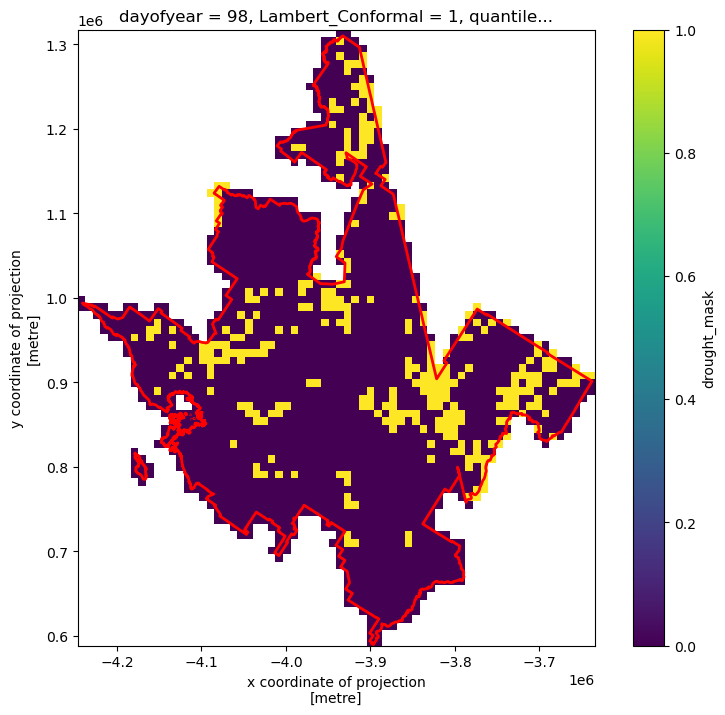

In [20]:
#plot test using plattecarree projection
fig = plt.figure(figsize=(10, 8))  # open matplotlib figure
ax = plt.axes()#projection=ccrs.PlateCarree())
region_masks[4]["drought_mask"].isel(time=827).plot(
    ax=ax,
    x="x",
    y="y",
    #transform=ccrs.PlateCarree(),
    )
gdf_reprojected.iloc[4:5].plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)#transform=ccrs.PlateCarree())

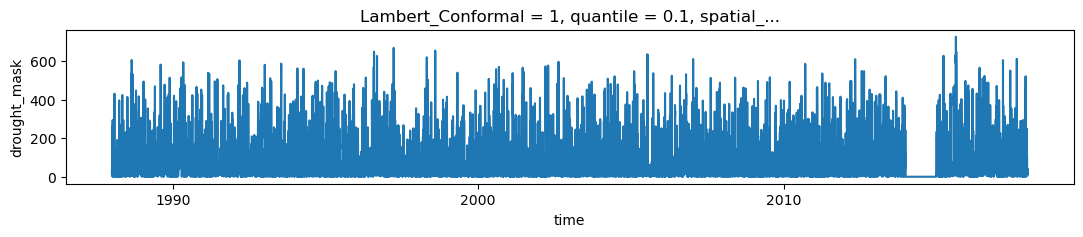

In [21]:
plt.figure(figsize=(13,2))
region_masks[4]["drought_mask"].sum(['x','y']).plot()

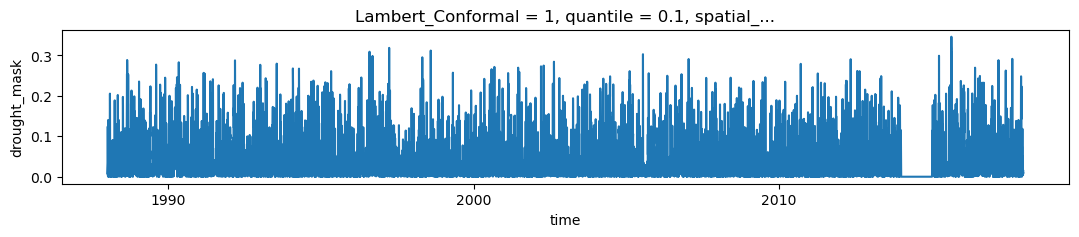

In [22]:
plt.figure(figsize=(13,2))
region_masks[4]["drought_mask"].mean(['x','y']).plot()

In [23]:
# find time index with max drought area
drought_area = region_masks[3]["drought_mask"].sum(['x','y']).compute()
max_drought_time = drought_area.argmax().item()
max_drought_time

1438

<Axes: title={'center': 'dayofyear = 113, Lambert_Conformal = 1, quantil...'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

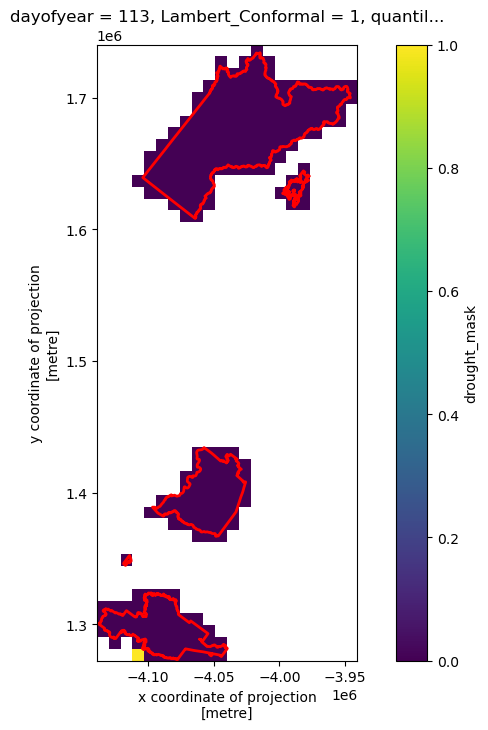

In [24]:
#plot test using plattecarree projection
fig = plt.figure(figsize=(10, 8))  # open matplotlib figure
ax = plt.axes()#projection=ccrs.PlateCarree())
region_masks[3]["drought_mask"].isel(time=112).plot(
    ax=ax,
    x="x",
    y="y",
    #transform=ccrs.PlateCarree(),
    )
gdf_reprojected.iloc[3:4].plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)#transform=ccrs.PlateCarree())

In [25]:
region_masks[3]["drought_mask"].isel(time=112).sum(['x','y']).values

array(1.)

In [26]:
for region_mask in region_masks:
    # produce a mean time series of drought area fraction
    region_mask['drought_area_fraction'] = region_mask["drought_mask"].mean(['x','y'])

In [ ]:
    region_mask['drought_area_fraction'] = region_mask["drought_mask"].mean(['x','y'])

for region_mask in region_masks:
    # save out the drought area fraction time series to netcdf
    output_file = f"{region_mask['region']}_{region_mask['simulation']}_{region_mask['resource']}_{region_mask['module']}_gwl{region_mask['gwl']}_drought_area_fraction.nc"
    region_mask['drought_area_fraction'].to_netcdf(output_file)